### Pipeline


#### Only Ubuntu/Linux/Debian

In [2]:
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages')
print(sys.path)

['C:\\Users\\ADMIN\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'C:\\Users\\ADMIN\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'C:\\Users\\ADMIN\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'C:\\Users\\ADMIN\\AppData\\Local\\Programs\\Python\\Python310', 'd:\\Documents\\Ki_8\\NLP\\Comment-Sentiment-Analysis\\myenv', '', 'd:\\Documents\\Ki_8\\NLP\\Comment-Sentiment-Analysis\\myenv\\lib\\site-packages', 'd:\\Documents\\Ki_8\\NLP\\Comment-Sentiment-Analysis\\myenv\\lib\\site-packages\\win32', 'd:\\Documents\\Ki_8\\NLP\\Comment-Sentiment-Analysis\\myenv\\lib\\site-packages\\win32\\lib', 'd:\\Documents\\Ki_8\\NLP\\Comment-Sentiment-Analysis\\myenv\\lib\\site-packages\\Pythonwin', '/usr/local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/site-packages']


In [3]:
import pandas as pd
import string
import re
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from transformers import pipeline
import py_vncorenlp
import os
# from CocCocTokenizer import PyTokenizer

d:\Documents\Ki_8\NLP\Comment-Sentiment-Analysis\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Ghi nh·ªõ th∆∞ m·ª•c g·ªëc ngay t·ª´ ƒë·∫ßu
PROJECT_ROOT = os.getcwd()
print("Thu m·ª•c g·ªëc:", PROJECT_ROOT)

Thu m·ª•c g·ªëc: d:\Documents\Ki_8\NLP\Comment-Sentiment-Analysis\pre-processing


In [5]:
ABSOLUTE_MODEL_PATH = os.path.abspath("../attribute_extractor/vncorenlp")
print("Using model path:", ABSOLUTE_MODEL_PATH)

# Kh·ªüi t·∫°o model t·ª´ th∆∞ m·ª•c local
vncorenlp_model = py_vncorenlp.VnCoreNLP(save_dir=ABSOLUTE_MODEL_PATH, max_heap_size="-Xmx2g")

Using model path: d:\Documents\Ki_8\NLP\Comment-Sentiment-Analysis\attribute_extractor\vncorenlp


### Kh·ªüi t·∫°o CorrectSpelling

In [4]:
os.path.join(PROJECT_ROOT, "vietnamese-correction-v2")

'd:\\School\\4thYear\\2ndSemester\\NLP\\Comment-Sentiment-Analysis\\pre-processing\\vietnamese-correction-v2'

In [5]:
corrector = pipeline("text2text-generation", model=os.path.join(PROJECT_ROOT, "vietnamese-correction-v2"))

Device set to use cuda:0


### L√†m s·∫°ch d·ªØ li·ªáu (xo√° h√†ng comment tr·ªëng ho·∫∑c nan)


In [18]:
df = pd.read_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings.csv"))

In [19]:
df.shape

(2413, 4)

In [20]:
df[~df["comment"].notna()]

product_id comment  rating                  source_file
534    iphone-15-plus     NaN       5   ratings\iphone-15-plus.csv
535    iphone-15-plus     NaN       5   ratings\iphone-15-plus.csv
536    iphone-15-plus     NaN       4   ratings\iphone-15-plus.csv
537    iphone-15-plus     NaN       5   ratings\iphone-15-plus.csv
538    iphone-15-plus     NaN       1   ratings\iphone-15-plus.csv
...               ...     ...     ...                          ...
2288  xiaomi-redmi-a3     NaN       5  ratings\xiaomi-redmi-a3.csv
2289  xiaomi-redmi-a3     NaN       4  ratings\xiaomi-redmi-a3.csv
2290  xiaomi-redmi-a3     NaN       5  ratings\xiaomi-redmi-a3.csv
2291  xiaomi-redmi-a3     NaN       5  ratings\xiaomi-redmi-a3.csv
2292  xiaomi-redmi-a3     NaN       3  ratings\xiaomi-redmi-a3.csv

[95 rows x 4 columns]

In [21]:
# Xo√° h√†ng ch·ª©a comment tr·ªëng ho·∫∑c nan
df = df[df["comment"].str.len() > 1]

In [22]:
df.shape

(2313, 4)

In [23]:
df[~df["comment"].notna()]

Empty DataFrame
Columns: [product_id, comment, rating, source_file]
Index: []

In [25]:
df.to_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings.csv"), index=False)

In [12]:
before_total_words = df['comment'].apply(lambda x: len(x.split())).sum()
before_total_words

53287

### Pipeline x·ª≠ l√Ω cho vƒÉn b·∫£n ti·∫øng Vi·ªát


In [26]:
class VietnamesePreprocessing:
    def __init__(self):
        # Load Vietnamese stopwords
        with open(
            os.path.join(PROJECT_ROOT, "../data/vietnamese.txt"), "r", encoding="utf-8"
        ) as file:
            self.stop_words = set(word.strip() for word in file.read().splitlines())
        with open(
            os.path.join(PROJECT_ROOT, "../data/vi-abbreviations.json"),
            "r",
            encoding="utf-8",
        ) as file:
            self.abbreviations = json.load(file)

    def clean(self, x: str) -> str:
        """Clean the text by removing unwanted characters or patterns."""
        x = re.sub(r"\s+", " ", x)
        x = x.strip()  # Remove leading/trailing spaces
        return x

    def to_lower(self, x: str) -> str:
        """Convert all text to lowercase."""
        return x.lower()

    def delete_stop_words(self, x: str) -> str:
        """Remove stopwords from the text."""
        return " ".join([word for word in x.split() if word not in self.stop_words])

    def replace_abbreviations(self, x: str) -> str:
        """Replace abbreviations in the text using the loaded dictionary."""
        return " ".join([self.abbreviations.get(word, word) for word in x.split()])

    def correct_spelling(self, x: str) -> str:
        """Correct spelling using the loaded model."""
        return corrector(x, max_length=2500)[0]["generated_text"]

    def __call__(self, x: str):
        """Apply the preprocessing pipeline to the input text."""
        print("Before:", x)
        x = self.clean(x)
        x = self.to_lower(x)
        x = self.replace_abbreviations(x)
        x = self.correct_spelling(x)
        x= self.to_lower(x)
        
        print("After: ", x)
        return x


preprocessor = VietnamesePreprocessing()

### Chia ra x·ª≠ l√Ω t·ª´ng batch d·ªØ li·ªáu

In [27]:
df_part1 = pd.read_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part1.csv"))
df_part2 = pd.read_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part2.csv"))
df_part3 = pd.read_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part3.csv"))
df_part4 = pd.read_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part4.csv"))
df_part5 = pd.read_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part5.csv"))

In [28]:
for idx, row in df_part1.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df_part1.at[idx, "comment_clean_stage1"] = preprocessor(row["comment"])  # Apply preprocessing

=====> Processing row 1
Before: ƒê·ª´ng mua, ko c√≥ linh ki·ªán.
After:  ƒë·ª´ng mua, kh√¥ng c√≥ linh ki·ªán.
=====> Processing row 2
Before: m√°y sao c≈©ng ƒë∆∞·ª£c gh√©t nh·∫•t c√°i zalo vui n√≥ b√°o hi·ªán tn cu·ªôc g·ªçi bu·ªìn th√¨ n√≥ im ru h√™n √≠t s√†i zalo ch·ª© s√†i nhi·ªÅu ch·∫Øc v·ª©c
After:  m√°y sao c≈©ng ƒë∆∞·ª£c gh√©t nh·∫•t c√°i zalo, vui n√≥ b√°o hi·ªán t√™n cu·ªôc g·ªçi, bu·ªìn th√¨ n√≥ im ru, h√™n √≠t s√†i zalo ch·ª© s√†i nhi·ªÅu ch·∫Øc t·ª©c.
=====> Processing row 3
Before: Chi·∫øc ƒëi·ªán tho·∫°i m·ªèng nh·∫•t t√¥i t·ª´ng d√πng, c≈©ng l√† chip 680 tr√™n m√°y n√†y m∆∞·ª£t h∆°n nhi·ªÅu 680 ·ªü SS a05s v·ª£ ƒëag d√πng
After:  chi·∫øc ƒëi·ªán tho·∫°i m·ªèng nh·∫•t t√¥i t·ª´ng d√πng, c≈©ng l√† chip 680 tr√™n m√°y n√†y, m∆∞·ª£t h∆°n nhi·ªÅu 680 ·ªü samsung a05s v·ª£ ƒëang d√πng.
=====> Processing row 4
Before: sao h√¥m t√¥i mua l·∫°i ko dc t·∫∑ng tai nghe nh∆∞ trong gi·ªõi thi·ªáu nh·ªâ h√¥m ƒë·∫•y t√¥i c≈©ng c√≥ xem th·∫•y khuy·∫øn m√£i
After:  sao h√¥m t√¥i mua l·∫°i 

In [35]:
for idx, row in df_part2.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df_part2.at[idx, "comment_clean_stage1"] = preprocessor(row["comment"])  # Apply preprocessing

=====> Processing row 1
Before: S·∫°c 25 l·∫ßn tu·ªôt 1% pin k√©m qu√°
After:  s·∫°c 25 l·∫ßn tu·ªôt 1% pin k√©m qu√°!
=====> Processing row 2
Before: M√†u xanh l√° ,96% b√°n l·∫°i bao nhi√™u ·∫°
After:  m√†u xanh l√° , 96% b√°n l·∫°i bao nhi√™u ·∫°?
=====> Processing row 3
Before: Sai m·ªõi 4thang m√† hao h·∫øt 3% pin h·ªëi h·∫≠n
After:  sai m·ªõi 4 th√°ng m√† hao h·∫øt 3% pin, h·ªëi h·∫≠n.
=====> Processing row 4
Before: M·ªõi mua ch∆∞a ƒëc 1th√°ng, d√πng c≈©ng m∆∞·ªõt nh∆∞ng l√¢u l√¢u ƒëag v√†o ·ª©ng d·ª•ng v√† treo v√† t·ª± tho√°t ra, ko h·ªâu l√Ω do
After:  m·ªõi mua ch∆∞a ƒë∆∞·ª£c 1 th√°ng, d√πng c≈©ng m∆∞·ªõt nh∆∞ng l√¢u l√¢u ƒëang v√†o ·ª©ng d·ª•ng v√† treo v√† t·ª± tho√°t ra, kh√¥ng hi·ªÉu l√Ω do.
=====> Processing row 5
Before: M·ªõi s√†i c√≥ 8th√°ng pin c√≤n 95%. Qu√° b∆∞a.
After:  m·ªõi s√†i c√≥ 8 th√°ng pin c√≤n 95%. qu√° b∆∞a.
=====> Processing row 6
Before: T√¥i mua ƒë∆∞·ª£c 4 th√°ng, gi·ªù m√†n h√¨nh ƒë·ªï m·ª±c. Khi nh√¢n vi√™n ki·ªÉm tra b√°o T√¥i c√≥ c·∫•n th√¢n m√°y

In [36]:
df_part2[["product_id", "comment", "comment_clean_stage1", "rating"]].to_csv(os.path.join(PROJECT_ROOT, "../data/processed_data/phone_ratings_part2.csv"), index=False)

In [37]:
for idx, row in df_part3.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df_part3.at[idx, "comment_clean_stage1"] = preprocessor(row["comment"])  # Apply preprocessing

=====> Processing row 1
Before: Ok
After:  ok!
=====> Processing row 2
Before: Nghe r√µ ch·ªØ to
After:  nghe r√µ ch·ªØ to.
=====> Processing row 3
Before: S·ª≠ d·ª•ng t·ªët, r·∫•t ok
After:  s·ª≠ d·ª•ng t·ªët, r·∫•t ok.
=====> Processing row 4
Before: B·ªã l√¥i m·ªõi ƒë·ªïi l·∫°i c√°i moi
After:  b·ªã l√¥i m·ªõi ƒë·ªïi l·∫°i c√°i m·ªõi.
=====> Processing row 5
Before: R·∫•t t·ªët
After:  r·∫•t t·ªët.
=====> Processing row 6
Before: T·ªët
After:  t·ªët.
=====> Processing row 7
Before: Ok
After:  ok!
=====> Processing row 8
Before: Ch∆∞a s·∫°c l·∫ßn n√†o c·ª•c s·∫°c ƒë√£ h∆∞
After:  ch∆∞a s·∫°c l·∫ßn n√†o c·ª•c s·∫°c ƒë√£ h∆∞.
=====> Processing row 9
Before: Mua l·∫°i m√°y ƒë√£ qua s·ª≠ d·ª•ng n√≥i chung pin c≈©ng ·ªïn. Nhi·ªÅu ng∆∞·ªùi ƒë√°nh gi√° n√≥i nhanh h·∫øt pin m·∫∑c d√π kh√¥ng nghe g·ªçi g√¨ nhi·ªÅu theo m√¨nh nghƒ© ch·∫Øc l√† t√πy chi·∫øc nhanh h·∫øt pin c√≥ chi·∫øc kh√¥ng. C≈©ng t√πy theo c√°ch s·∫°c ƒëi·ªán tho·∫°i n·ªØa. ƒê√°nh gi√° chung th√¨ m√°y loa to nghe g·ªçi r√µ. Ph

In [38]:
df_part3[["product_id", "comment", "comment_clean_stage1", "rating"]].to_csv(os.path.join(PROJECT_ROOT, "../data/processed_data/phone_ratings_part3.csv"), index=False)

### Ch·∫°y l·∫°i pipeline (kh√¥ng c√≥ b∆∞·ªõc spell check)

In [6]:
df = pd.read_csv("../../data/processed_data/phone_ratings_part.csv")
df = df[df["comment"].str.len() > 1]

In [9]:
class VietnamesePreprocessingWithoutSpellCheck:
    def __init__(self):
        # Load Vietnamese stopwords
        pd_stopword = pd.read_csv('../../data/stopword/new_vietnamese_stopwords.csv')
        self.stop_words = set(pd_stopword[pd_stopword["is_stopword"] == 1]["word"].tolist())
        with open("../../data/vi-abbreviations.json", "r", encoding="utf-8") as file:
            self.abbreviations = json.load(file)
        with open("../../data/compound_words.txt", "r", encoding="utf-8") as file:
            self.compound_words = set(word.strip() for word in file.read().splitlines())
        # self.cocCocTokenizer = PyTokenizer(load_nontone_data=True)
        self.vncorenlp_model = vncorenlp_model


    def clean(self, x: str) -> str:
        """Clean the text by removing unwanted characters or patterns."""
        x = re.sub(r"\s+", " ", x) # replace multiple spaces with a single space

        # Replace '10d', '10ƒë', '10 ƒëi·ªÉm' to 't·ªët' if > 8, 'kh√°' if > 5, 't·ªá' if <= 5 (0-5)
        x = re.sub(r"\b(\d{1,2})(d|ƒë)\b", lambda match: "t·ªët" if int(match.group(1)) > 8 else "t·∫°m" if int(match.group(1)) > 4 else "t·ªá", x) 

        x = re.sub(r"\b0", "", x)  # remove digit 0 at the beginning

        # Remove phone number
        x = re.sub(r"(\d{10})", "", x) # remove phone number vietnam like 0954223654, 0856452325, 0123456789
        x = re.sub(r"(xx\s*){2,}", "", x) # remove phone number vietnam like xxx223654 hay 0905***654
        x = re.sub(r"(\*\s*)+", "", x)
        x = re.sub(r"\b\d+[xX\*]+\d+\b", "", x)  # Xo√° c√°c d√£y s·ªë c√≥ ch·ª©a x ho·∫∑c *

        x = re.sub(r"\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b", "", x) # remove email
        x = re.sub(r"\b\d+\b", lambda match: "" if int(match.group(0)) >= 100 else match.group(0), x) # remove number stand alone
        
        x = re.sub(r"\b\d+(?:\.\d+)?(tr\d+|tr|k)\b", "", x) # Remove numbers >= 100 or numbers with 'tr' or 'k' (1tr5, 130k, 11940k)
        x = re.sub(r"\b\d+(?:\.\d+)?tr\d+(?:\.\d+)?k\b", "", x) # Remove like that 11tr990k

        # Split x% to x % example 70% to 70 %
        x = re.sub(r"(\d+)%", r"\1 %", x)
        x = re.sub(r"\s+", " ", x) # replace multiple spaces with a single space
        x = x.strip()  # Remove leading/trailing spaces
        return x

    def to_lower(self, x: str) -> str:
        """Convert all text to lowercase."""
        return x.lower()

    def delete_punctuation(self, x: str) -> str:
        """Remove punctuation from the text."""
        return x.translate(str.maketrans("", "", string.punctuation))

    def tokenize_text(self, x: str) -> list:
        """Tokenize the text into words."""
        return " ".join(vncorenlp_model.word_segment(x))

    def delete_stop_words(self, x: str) -> str:
        """Remove stopwords from the text."""
        return " ".join([word for word in x.split() if word not in self.stop_words])
    
    def replace_compound_words(self, x: str) -> str:
        # Thay c√°c t·ª´ trong comment c√≥ compound ƒë·ªçc ƒë∆∞·ª£c t·ª´ file compound_words.txt
        for word in self.compound_words:
            x = x.replace(word, word.replace(" ", "_"))
        return x

    def replace_abbreviations(self, x: str) -> str:
        """Replace abbreviations in the text using the loaded dictionary."""
        return " ".join([self.abbreviations.get(word, word) for word in x.split()])

    def correct_spelling(self, x: str) -> str:
        """Correct spelling using the loaded model."""
        return corrector(x, max_length=2500)[0]["generated_text"]

    def __call__(self, x: str):
        """Apply the preprocessing pipeline to the input text."""
        before_x = x
        x = self.clean(x)
        x = self.to_lower(x)
        x = self.replace_abbreviations(x)
        x = self.delete_punctuation(x)
        # x = self.replace_compound_words(x)
        x = self.tokenize_text(x)
        x = self.delete_stop_words(x)

        if before_x != x:
            print("Before:", before_x)
            print("After:", x)
        return x
    

without_spellcheck_preprocessor = VietnamesePreprocessingWithoutSpellCheck()

In [10]:
for idx, row in df.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df.at[idx, "comment_clean_stage2"] = without_spellcheck_preprocessor(row["comment_clean_stage1"])  # Apply preprocessing

=====> Processing row 1
Before: ƒë·ª´ng mua, kh√¥ng c√≥ linh ki·ªán.
After: ƒë·ª´ng mua kh√¥ng linh_ki·ªán
=====> Processing row 2
Before: m√°y sao c≈©ng ƒë∆∞·ª£c gh√©t nh·∫•t c√°i zalo, vui n√≥ b√°o hi·ªán t√™n cu·ªôc g·ªçi, bu·ªìn th√¨ n√≥ im ru, h√™n √≠t s√†i zalo ch·ª© s√†i nhi·ªÅu ch·∫Øc t·ª©c.
After: m√°y sao ƒë∆∞·ª£c gh√©t nh·∫•t vui b√°o hi·ªán cu·ªôc_g·ªçi bu·ªìn im ru h√™n √≠t x√†i ch·ª© x√†i nhi·ªÅu ch·∫Øc t·ª©c
=====> Processing row 3
Before: chi·∫øc ƒëi·ªán tho·∫°i m·ªèng nh·∫•t t√¥i t·ª´ng d√πng, c≈©ng l√† chip 680 tr√™n m√°y n√†y, m∆∞·ª£t h∆°n nhi·ªÅu 680 ·ªü samsung a05s v·ª£ ƒëang d√πng.
After: ƒëi·ªán_tho·∫°i m·ªèng nh·∫•t d√πng chip tr√™n m√°y m∆∞·ª£t h∆°n nhi·ªÅu samsung a05s v·ª£ d√πng
=====> Processing row 4
Before: sao h√¥m t√¥i mua l·∫°i kh√¥ng ƒë∆∞·ª£c t·∫∑ng tai nghe nh∆∞ trong gi·ªõi thi·ªáu nh·ªâ, h√¥m ƒë·∫•y t√¥i c≈©ng c√≥ xem th·∫•y khuy·∫øn m√£i.
After: sao h√¥m mua kh√¥ng ƒë∆∞·ª£c t·∫∑ng tai trong gi·ªõi_thi·ªáu h√¥m ƒë·∫•y th·∫•y khuy·∫øn_m√£i
=====> Pr

In [11]:
df[["product_id", "comment", "comment_clean_stage1", "rating"]].to_csv(os.path.join(PROJECT_ROOT, "../data/processed_data/phone_ratings.csv"), index=False)

In [13]:
result = without_spellcheck_preprocessor("vu·ªët m∆∞·ª£t m√† pin tr√¢u ƒë·ªß d√πng 8h online 4g li√™n t·ª•c camera ch·ª•p ban ƒë√™m t·ªët m√†ng h√¨nh c√≥ ƒë·ªô t∆∞∆°ng ph·∫£n r√µ n√©t loa ngo√†i nghe nh·∫°c hay c√≥ phi√™n b·∫£n b·ªô nh·ªõ 256gb tho·∫£i m√°i l∆∞u tr·ªØ ·∫£nh v√† ·ª©ng d·ª•ng ƒë·ªëi v·ªõi ri√™ng m√¨nh th√¨ samsung lu√¥n l·∫Øng nghe ph√°t tri·ªÉn ƒë·ªÉ ph√π h·ª£p t·ª´ng kh√°ch h√†ng t·ª´ b√¨nh d√¢n ƒë·∫øn cao c·∫•p m√¨nh lu√¥n")
print(result)

Before: vu·ªët m∆∞·ª£t m√† pin tr√¢u ƒë·ªß d√πng 8h online 4g li√™n t·ª•c camera ch·ª•p ban ƒë√™m t·ªët m√†ng h√¨nh c√≥ ƒë·ªô t∆∞∆°ng ph·∫£n r√µ n√©t loa ngo√†i nghe nh·∫°c hay c√≥ phi√™n b·∫£n b·ªô nh·ªõ 256gb tho·∫£i m√°i l∆∞u tr·ªØ ·∫£nh v√† ·ª©ng d·ª•ng ƒë·ªëi v·ªõi ri√™ng m√¨nh th√¨ samsung lu√¥n l·∫Øng nghe ph√°t tri·ªÉn ƒë·ªÉ ph√π h·ª£p t·ª´ng kh√°ch h√†ng t·ª´ b√¨nh d√¢n ƒë·∫øn cao c·∫•p m√¨nh lu√¥n
After: vu·ªët m∆∞·ª£t_m√† pin tr√¢u ƒë·ªß d√πng 8h online 4g li√™n_t·ª•c camera ch·ª•p ban_ƒë√™m t·ªët m√†ng h√¨nh ƒë·ªô t∆∞∆°ng_ph·∫£n r√µ n√©t loa nh·∫°c hay phi√™n_b·∫£n b·ªô_nh·ªõ 256gb tho·∫£i_m√°i l∆∞u_tr·ªØ ·∫£nh ·ª©ng_d·ª•ng ri√™ng samsung l·∫Øng_nghe ph√°t_tri·ªÉn ph√π_h·ª£p kh√°ch_h√†ng b√¨nh_d√¢n cao_c·∫•p
vu·ªët m∆∞·ª£t_m√† pin tr√¢u ƒë·ªß d√πng 8h online 4g li√™n_t·ª•c camera ch·ª•p ban_ƒë√™m t·ªët m√†ng h√¨nh ƒë·ªô t∆∞∆°ng_ph·∫£n r√µ n√©t loa nh·∫°c hay phi√™n_b·∫£n b·ªô_nh·ªõ 256gb tho·∫£i_m√°i l∆∞u_tr·ªØ ·∫£nh ·ª©ng_d·ª•ng ri√™ng samsung l·∫Øng_nghe ph√°t_tri·ªÉn ph√

### Ph√¢n t√≠ch s·ªë l∆∞·ª£ng t·ª´


In [14]:
df.head()

product_id                                            comment  \
0  honor-x8b                         ƒê·ª´ng mua, ko c√≥ linh ki·ªán.   
1  honor-x8b  m√°y sao c≈©ng ƒë∆∞·ª£c gh√©t nh·∫•t c√°i zalo vui n√≥ b√°...   
2  honor-x8b  Chi·∫øc ƒëi·ªán tho·∫°i m·ªèng nh·∫•t t√¥i t·ª´ng d√πng, c≈©ng...   
3  honor-x8b  sao h√¥m t√¥i mua l·∫°i ko dc t·∫∑ng tai nghe nh∆∞ tr...   
4  honor-x8b          E Mua ƒëc 1 tu·∫ßn tr·∫£ l·∫°i m·∫•t bao nhi√™u % ·∫°   

                                comment_clean_stage1  rating  \
0                      ƒë·ª´ng mua, kh√¥ng c√≥ linh ki·ªán.       1   
1  m√°y sao c≈©ng ƒë∆∞·ª£c gh√©t nh·∫•t c√°i zalo, vui n√≥ b...       3   
2  chi·∫øc ƒëi·ªán tho·∫°i m·ªèng nh·∫•t t√¥i t·ª´ng d√πng, c≈©ng...       5   
3  sao h√¥m t√¥i mua l·∫°i kh√¥ng ƒë∆∞·ª£c t·∫∑ng tai nghe n...       4   
4  em mua ƒë∆∞·ª£c m·ªôt tu·∫ßn tr·∫£ l·∫°i m·∫•t bao nhi√™u ph·∫ß...       3   

                                comment_clean_stage2  
0                           ƒë·ª´ng mua kh√¥ng linh_ki·ªán  
1  m√°y sao ƒë∆∞·ª£c gh√©t nh·∫•t vui b√°o hi·ªán cu·ªôc_g·ªçi b...  
2  ƒëi·ªán_tho·∫°i m·ªèng nh·∫•t d√πng chip tr√™n m√°y m∆∞·ª£t h...  
3  sao h√¥m mua kh√¥ng ƒë∆∞·ª£c t·∫∑ng tai trong gi·ªõi_thi...  
4          mua ƒë∆∞·ª£c tu·∫ßn tr·∫£ m·∫•t bao_nhi√™u ph·∫ßn_trƒÉm

In [15]:
df.shape

(2312, 5)

In [17]:
after_total_words = df['comment_clean_stage2'].apply(lambda x: len(x.split())).sum()
after_total_words

np.int64(33713)

### Check l·∫°i data sau khi x·ª≠ l√Ω d·ªØ li·ªáu

![image.png](../assets/illustration/incorrect-stopwords.png)


In [18]:
df[df["comment_clean_stage2"].apply(lambda x: len(x) == 0)]

product_id     comment comment_clean_stage1  rating  \
158     iphone-12        Sang                sang.       4   
1154  mobell-m539  xxxx887398          xxxx887398.       4   

     comment_clean_stage2  
158                        
1154

In [19]:
df = df[df["comment_clean_stage2"].str.len() > 1]

In [20]:
df[df["comment_clean_stage2"].apply(lambda x: len(x) == 0)]

Empty DataFrame
Columns: [product_id, comment, comment_clean_stage1, rating, comment_clean_stage2]
Index: []

Check l·∫°i th√¨ th·∫•y m·ªôt s·ªë t·ª´ kh√¥ng n√™n xem l√† stopword nh∆∞ "t·ªët"


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2310 entries, 0 to 2311
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   product_id            2310 non-null   object
 1   comment               2310 non-null   object
 2   comment_clean_stage1  2310 non-null   object
 3   rating                2310 non-null   int64 
 4   comment_clean_stage2  2310 non-null   object
dtypes: int64(1), object(4)
memory usage: 108.3+ KB


In [22]:
df["word_count"] = df["comment_clean_stage2"].astype(str).apply(lambda x: len(x.split()))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14468\2843146802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word_count"] = df["comment_clean_stage2"].astype(str).apply(lambda x: len(x.split()))


In [23]:
df[["comment_clean_stage2", "word_count"]].sort_values(
    by="word_count", ascending=False
).head()

comment_clean_stage2  word_count
1355  th·∫•y kh√¥ng ·ªïn ch·ªó ƒë·ªãnh_v·ªã th·ªùi_ti·∫øt tr√† c·ªï t√¢n...         202
1241  m√°y thi·∫øt_k·∫ø ƒë·∫πp ƒë·ªô ho√†n_thi·ªán r·∫•t t·ªët m·∫∑t m·∫∑t...         170
615   1 nh√¢n_vi√™n b√°n ƒëi·ªán_tho·∫°i r·∫•t nhi·ªát_t√¨nh t·ªët2...         169
1837  t·ªïng_h·ª£p l·ªói tr√™n mk35 h∆°n s·ª≠_d·ª•ng nh·∫•t m·ªü v√¢n...         141
751   khuy√™n √Ω_ƒë·ªãnh mua 16 kh√¥ng n√™n muanh·∫•t mua ƒëi·ªá...         124

### Bi·ªÉu ƒë·ªì t·∫ßn su·∫•t


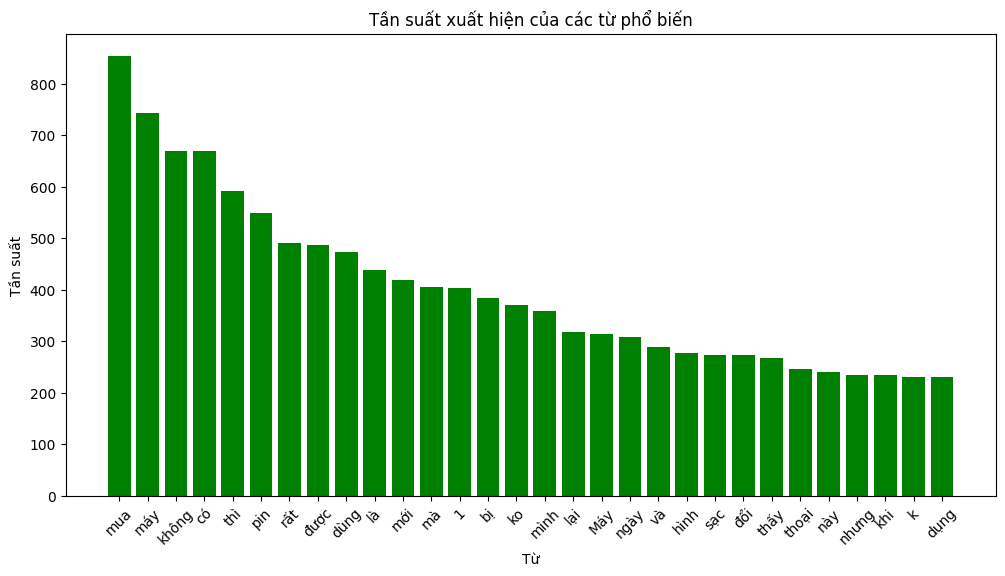

In [24]:
# T·∫°o bi·ªÉu ƒë·ªì t·∫ßn su·∫•t t·ª´
all_words = " ".join(df["comment"].astype(str)).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)  # L·∫•y 20 t·ª´ ph·ªï bi·∫øn nh·∫•t

words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color="green")
plt.xticks(rotation=45)
plt.xlabel("T·ª´")
plt.ylabel("T·∫ßn su·∫•t")
plt.title("T·∫ßn su·∫•t xu·∫•t hi·ªán c·ªßa c√°c t·ª´ ph·ªï bi·∫øn")
plt.show()

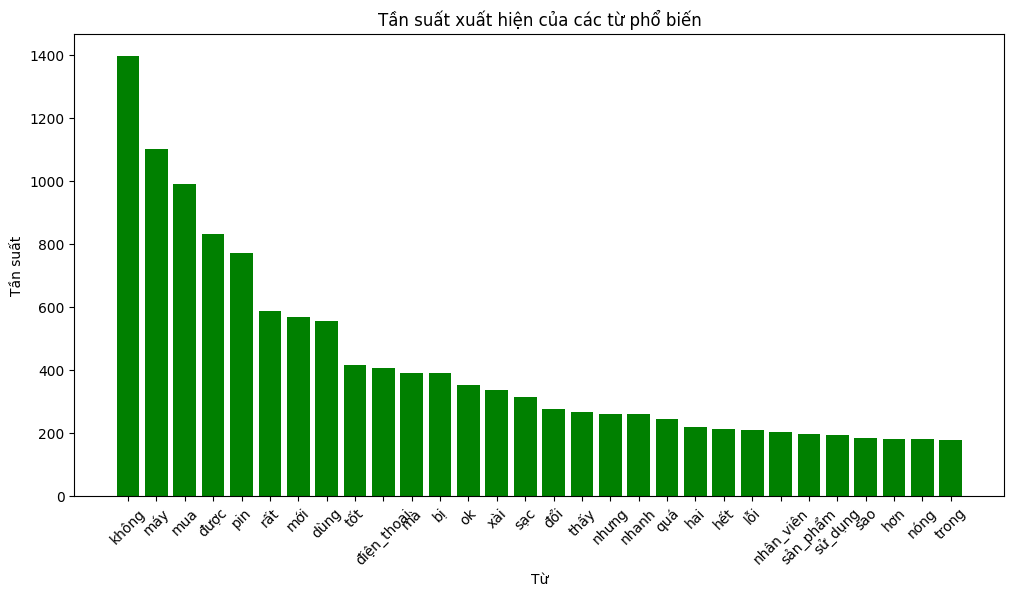

In [25]:
# T·∫°o bi·ªÉu ƒë·ªì t·∫ßn su·∫•t t·ª´
all_words = " ".join(df["comment_clean_stage2"].astype(str)).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)  # L·∫•y 20 t·ª´ ph·ªï bi·∫øn nh·∫•t

words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color="green")
plt.xticks(rotation=45)
plt.xlabel("T·ª´")
plt.ylabel("T·∫ßn su·∫•t")
plt.title("T·∫ßn su·∫•t xu·∫•t hi·ªán c·ªßa c√°c t·ª´ ph·ªï bi·∫øn")
plt.show()

### Data before

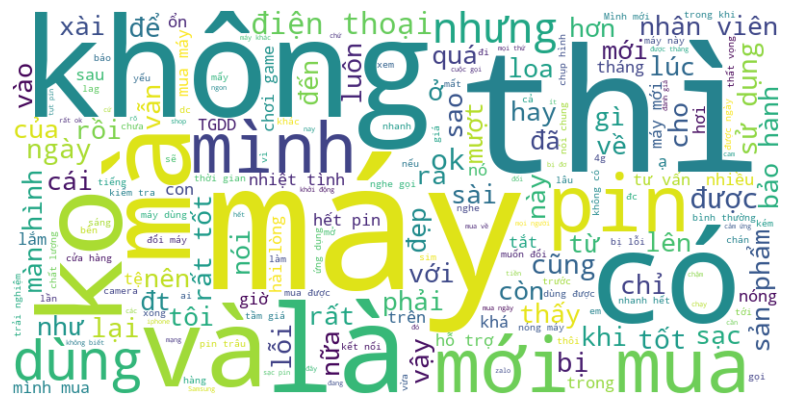

In [26]:
all_comments = " ".join(df["comment"])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    all_comments
)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # No axes for word cloud
plt.show()

### Data after

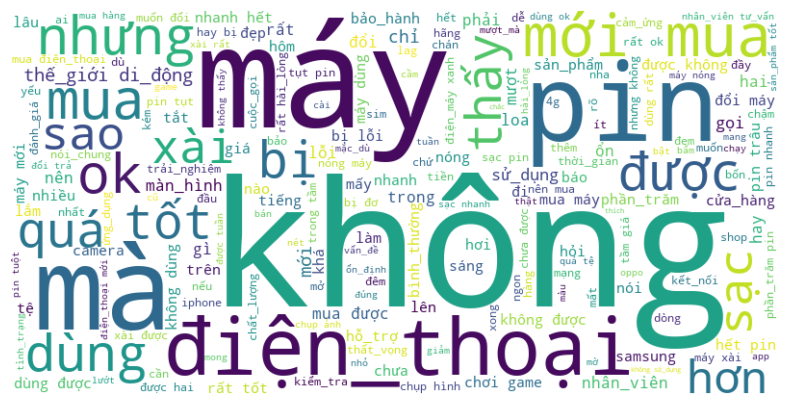

In [27]:
all_comments = " ".join(df["comment_clean_stage2"])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    all_comments
)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # No axes for word cloud
plt.show()

### Check l·∫°i k·∫øt qu·∫£ sau khi tokenize
- Underthesea
![image.png](../assets/illustration/incorrect-tokenize.png)

- C·ªëc c·ªëc tokenizer

![image.png](../assets/illustration/coccoc-tokenizer.png)

In [28]:
# T√¨m c√°c ph·∫ßn t·ª≠ ch·ª©ach·ª©a t·ª´ 'pin' b√™n trong c√°c b√¨nh lu·∫≠n ·ªü m·∫£ng all_comments
pin_comments = set([comment for comment in all_comments.split() if "pin" in comment])
pin_comments

{'giapin',
 'l·∫°ipin',
 'm∆∞·ª£tpin',
 'm·∫°nhpin',
 'philippines',
 'pin',
 'pinh·ªèi',
 'pint·∫ßm',
 'pinƒë·ªÉ',
 'r√µpin',
 'tapin',
 'ƒë√®n_pin',
 'ƒë∆°pin',
 'ƒë·∫ønpin'}

In [29]:
df.drop(columns=["word_count"], inplace=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14468\1730347537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["word_count"], inplace=True)


In [31]:
columns = ["product_id", "comment", "comment_clean_stage2", "rating"]

df = df[columns]
df

product_id                                            comment  \
0                honor-x8b                         ƒê·ª´ng mua, ko c√≥ linh ki·ªán.   
1                honor-x8b  m√°y sao c≈©ng ƒë∆∞·ª£c gh√©t nh·∫•t c√°i zalo vui n√≥ b√°...   
2                honor-x8b  Chi·∫øc ƒëi·ªán tho·∫°i m·ªèng nh·∫•t t√¥i t·ª´ng d√πng, c≈©ng...   
3                honor-x8b  sao h√¥m t√¥i mua l·∫°i ko dc t·∫∑ng tai nghe nh∆∞ tr...   
4                honor-x8b          E Mua ƒëc 1 tu·∫ßn tr·∫£ l·∫°i m·∫•t bao nhi√™u % ·∫°   
...                    ...                                                ...   
2307  xiaomi-redmi-note-13                                     Camera t·ªá th·∫≠t   
2308  xiaomi-redmi-note-13  D√πng 1 th·ªùi gian c√≥ hi·ªán t∆∞·ª£ng lang gi·∫≠t, ko c...   
2309  xiaomi-redmi-note-13  T√¥i th·∫•y con note 13 n√†y ch·ªâ m·ªói pin kh√¥ng ·ªïn ...   
2310  xiaomi-redmi-note-13  v·ª´a mua xong th√¨ gi√° gi·∫£m n√™n nh√¨n c√°i ƒëi·ªán th...   
2311  xiaomi-redmi-note-13  Kh√¥ng s·ª≠ d·ª•ng c≈©ng hao pin. T·ªëi t·ª´ 69% s√°ng th...   

                                   comment_clean_stage2  rating  
0                              ƒë·ª´ng mua kh√¥ng linh_ki·ªán       1  
1     m√°y sao ƒë∆∞·ª£c gh√©t nh·∫•t vui b√°o hi·ªán cu·ªôc_g·ªçi b...       3  
2     ƒëi·ªán_tho·∫°i m·ªèng nh·∫•t d√πng chip tr√™n m√°y m∆∞·ª£t h...       5  
3     sao h√¥m mua kh√¥ng ƒë∆∞·ª£c t·∫∑ng tai trong gi·ªõi_thi...       4  
4             mua ƒë∆∞·ª£c tu·∫ßn tr·∫£ m·∫•t bao_nhi√™u ph·∫ßn_trƒÉm       3  
...                                                 ...     ...  
2307                                     camera t·ªá th·∫≠t       5  
2308  d√πng th·ªùi_gian hi·ªán_t∆∞·ª£ng l·ªùn gi·∫≠t kh√¥ng c·∫£m_·ª©...       3  
2309  th·∫•y note 13 ch·ªâ pin kh√¥ng ·ªïn nhanh h·∫øt pin kh...       3  
2310  mua xong gi√° gi·∫£m n√™n ƒëi·ªán_tho·∫°i kh√¥ng ∆∞a n·ªïi ...       2  
2311  kh√¥ng s·ª≠_d·ª•ng hao pin t·ªëi 69 ph·∫ßn_trƒÉm s√°ng th...       1  

[2310 rows x 4 columns]

In [33]:
df.to_csv("../../data/phone_ratings_cleaned.csv", index=False)